In [1]:
import h5py
import healpy as hp
import numpy as np
import os
import matplotlib.pyplot as plt

/home/dhayaa/ipykernel_1849091/564753020.py:23: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.where(Map > 0, np.log10(Map), hp.UNSEEN), cmap = 'magma')


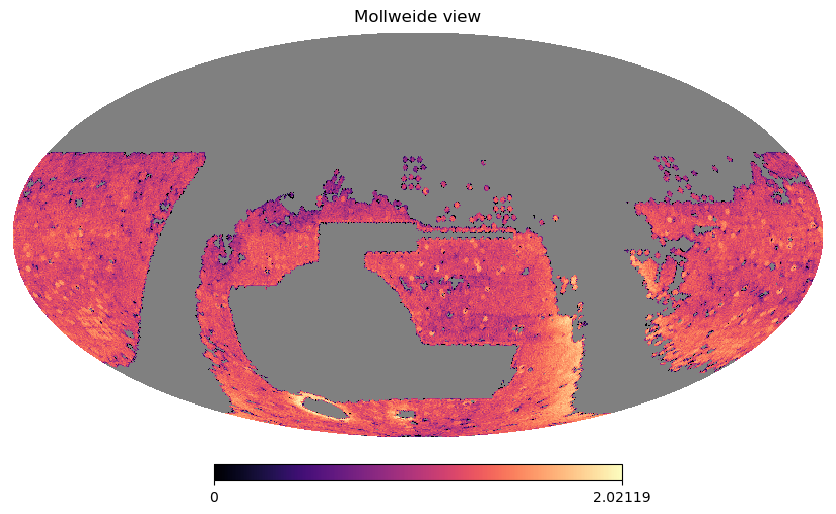

In [2]:
with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20241003.hdf', 'r') as f:
    
    ra   = f['RA'][::1000]
    dec  = f['DEC'][::1000]
    
    nside = 128
    pix = hp.ang2pix(nside, ra, dec, lonlat = True)
    
Map = np.bincount(pix, minlength = hp.nside2npix(nside))


with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20240209.hdf', 'r') as f:
    
    ra   = f['RA'][::1000]
    dec  = f['DEC'][::1000]
    
    nside = 128
    pix = hp.ang2pix(nside, ra, dec, lonlat = True)
    
Map += np.bincount(pix, minlength = hp.nside2npix(nside))


hp.mollview(np.where(Map > 0, np.log10(Map), hp.UNSEEN), cmap = 'magma')


ra = np.linspace(0, 360, 1000)

msk  = np.piecewise(ra, 
                    [((310 < ra) & (ra <= 360)) | (ra < 50), 
                     (ra < 310) & (ra > 180)],
                    [lambda ra: np.where((310 < ra) & (ra < 350), 3.5, np.where(ra > 350, (ra - 350) * (18 - 3.5)/(20) + 3.5, (ra + 10)  * (18 - 3.5)/(20) + 3.5) ),
                     lambda ra: np.where(ra < 225, 30 - (30 - 12)/(225 - 200) * (ra - 200), 12.),
                     lambda ra: 40])

# hp.projplot(ra, msk,  lonlat = True, ls = '--', color = 'k');

# fiducial catalog alone

In [2]:
def de_island_ify(ra, dec):
    
    mask = np.invert(dec > np.where((310 < ra) & (ra < 350), 
                                            3.5, 
                                            np.where(ra > 350, 
                                                     (ra - 350) * (18 - 3.5)/(20) + 3.5,
                                                     (ra + 10)  * (18 - 3.5)/(20) + 3.5)
                                          )
                           )
    return mask

In [3]:
with h5py.File('/project/chihway/data/decade/metacal_gold_combined_mask_20241003.hdf', 'r') as f:
    msk    = f['baseline_mcal_mask_noshear'][:] > 0
    
with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20241003.hdf', 'r') as f:
    
    ra   = f['RA'][:]
    dec  = f['DEC'][:]
    
    Flags  = f['mcal_flags'][:]
    SNR    = f['mcal_s2n_noshear'][:]
    T      = f['mcal_T_noshear'][:]
    Tratio = f['mcal_T_ratio_noshear'][:]
    g1, g2 = f['mcal_g_noshear'][:].T
    
    
    m  = 30 - 2.5 * np.log10(f['mcal_flux_noshear'][:])
    
    mask = (
        (Flags == 0) & 
        (SNR > 10) & 
        (SNR < 1000) & 
        (T < 10) & 
        (Tratio > 0.5) & 
        np.invert((T > 2) & (SNR < 30)) & 
        np.invert((np.log10(T) < (22.25 - m[:,0])/3.5) & (g1**2 + g2**2 > 0.8**2))
    )
    
    mcal_pz_mask = ((m[:,1] < 23.5) & (m[:,1] > 18) &
                    (m[:,0] < 26)   & (m[:,0] > 15) &
                    (m[:,2] < 26)   & (m[:,2] > 15) &
                    (m[:,0] - m[:,1] < 4)   & (m[:,0] - m[:,1] > -1.5) &
                    (m[:,1] - m[:,2] < 4)   & (m[:,1] - m[:,2] > -1.5))
    
    nside = 1024
    pix = hp.ang2pix(nside, ra, dec, lonlat = True)
    pi2 = hp.ang2pix(4096, ra, dec, lonlat = True)
    
    GOLD = hp.read_map('/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5_MCs2.fits')
    Gmsk = GOLD[pi2] == 0
    
    GOLD2 = hp.read_map('/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5_MCs2_DESY6.fits')
    Gmsk2 = GOLD2[pi2] == 0
    
    island_mask = de_island_ify(ra, dec)
    
    MASK = mask & Gmsk & island_mask & mcal_pz_mask

/scratch/local/jobs/27954886/ipykernel_1626088/99773428.py:16: RuntimeWarning: invalid value encountered in log10
  m  = 30 - 2.5 * np.log10(f['mcal_flux_noshear'][:])
/scratch/local/jobs/27954886/ipykernel_1626088/99773428.py:25: RuntimeWarning: invalid value encountered in log10
  np.invert((np.log10(T) < (22.25 - m[:,0])/3.5) & (g1**2 + g2**2 > 0.8**2))


62346266 4135.452233747143 4.18779041404378


/scratch/local/jobs/27954886/ipykernel_1626088/3469449593.py:9: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.where(Map > 0, np.log10(Map), hp.UNSEEN), cmap = 'magma')


Text(0.6, 0.65, '$n_{gal} = 4.19$ [$\\rm arcmin^{-2}$]')

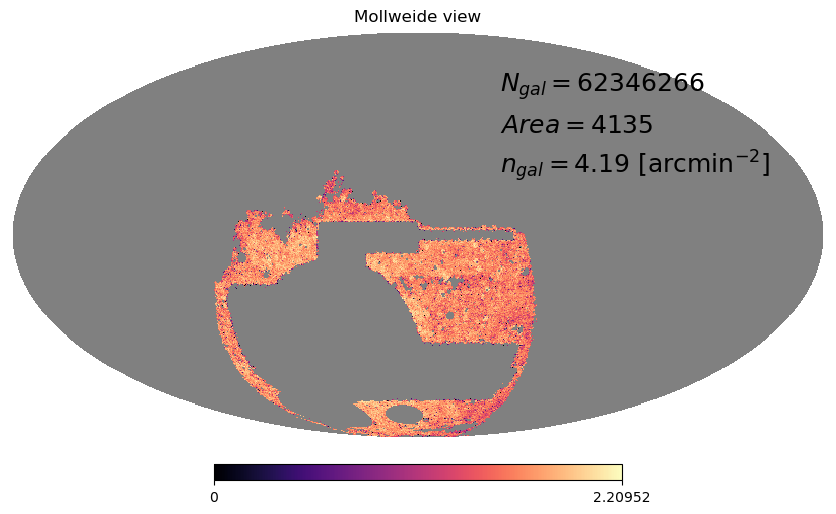

In [6]:
Map = np.bincount(pix[mask & Gmsk2 & island_mask & mcal_pz_mask], minlength = hp.nside2npix(nside))

Ngal = np.sum(Map)
Area = np.sum(Map > 0) * hp.nside2pixarea(nside, degrees = True)
ngal = Ngal/Area/(60*60)

print(Ngal, Area, ngal)

hp.mollview(np.where(Map > 0, np.log10(Map), hp.UNSEEN), cmap = 'magma')

plt.text(0.6, 0.85, r'$N_{gal} = %d$' % Ngal, color = 'k', fontsize = 18, transform = plt.gca().transAxes)
plt.text(0.6, 0.75, r'$Area = %d$' % Area, color = 'k', fontsize = 18, transform = plt.gca().transAxes)
plt.text(0.6, 0.65, r'$n_{gal} = %0.2f$ [$\rm arcmin^{-2}$]' % ngal, color = 'k', fontsize = 18, transform = plt.gca().transAxes)

66398327 4265.257520055134 4.324235907327774


/scratch/local/jobs/27954886/ipykernel_1626088/3612944429.py:9: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.where(Map > 0, np.log10(Map), hp.UNSEEN), cmap = 'magma')


Text(0.6, 0.65, '$n_{gal} = 4.32$ [$\\rm arcmin^{-2}$]')

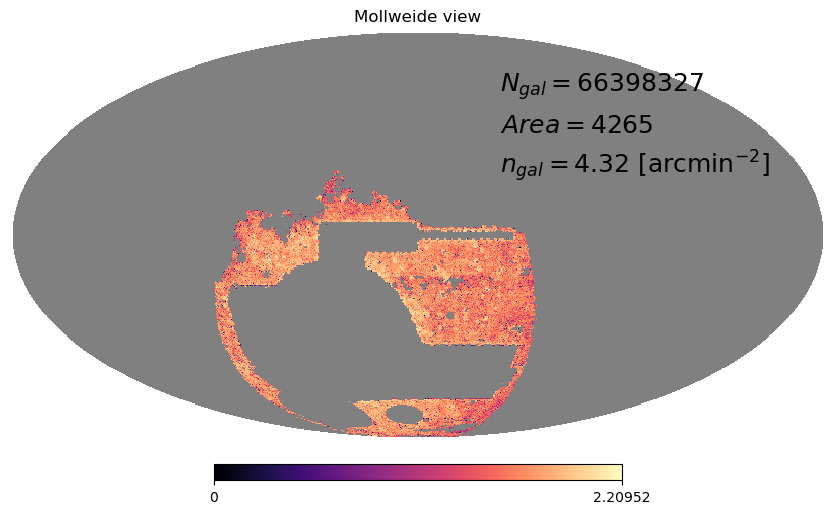

In [5]:
Map = np.bincount(pix[mask & Gmsk & island_mask & mcal_pz_mask], minlength = hp.nside2npix(nside))

Ngal = np.sum(Map)
Area = np.sum(Map > 0) * hp.nside2pixarea(nside, degrees = True)
ngal = Ngal/Area/(60*60)

print(Ngal, Area, ngal)

hp.mollview(np.where(Map > 0, np.log10(Map), hp.UNSEEN), cmap = 'magma')

plt.text(0.6, 0.85, r'$N_{gal} = %d$' % Ngal, color = 'k', fontsize = 18, transform = plt.gca().transAxes)
plt.text(0.6, 0.75, r'$Area = %d$' % Area, color = 'k', fontsize = 18, transform = plt.gca().transAxes)
plt.text(0.6, 0.65, r'$n_{gal} = %0.2f$ [$\rm arcmin^{-2}$]' % ngal, color = 'k', fontsize = 18, transform = plt.gca().transAxes)

673590232 7177.963824435257 26.067057783270307


/scratch/local/jobs/27954886/ipykernel_1626088/3165926643.py:9: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.where(Map > 0, np.log10(Map), hp.UNSEEN), cmap = 'magma')


Text(0.6, 0.65, '$n_{gal} = 26.07$ [$\\rm arcmin^{-2}$]')

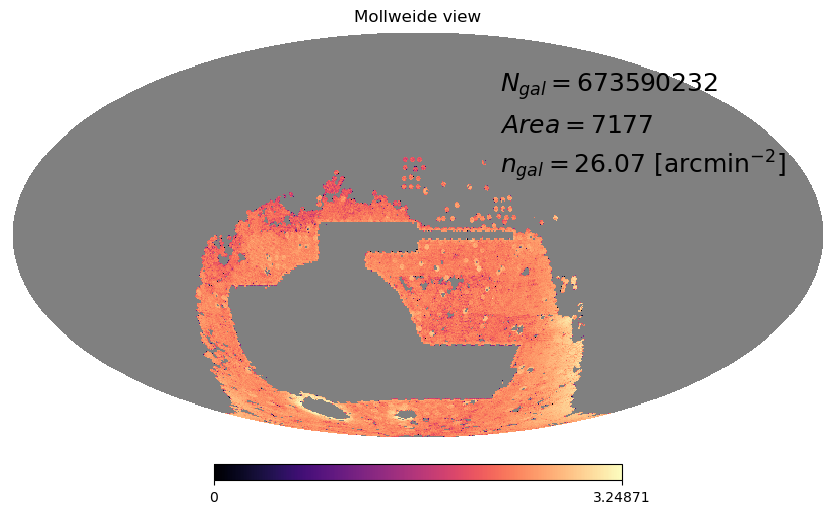

In [4]:
Map = np.bincount(pix, minlength = hp.nside2npix(nside))

Ngal = np.sum(Map)
Area = np.sum(Map > 0) * hp.nside2pixarea(nside, degrees = True)
ngal = Ngal/Area/(60*60)

print(Ngal, Area, ngal)

hp.mollview(np.where(Map > 0, np.log10(Map), hp.UNSEEN), cmap = 'magma')

plt.text(0.6, 0.85, r'$N_{gal} = %d$' % Ngal, color = 'k', fontsize = 18, transform = plt.gca().transAxes)
plt.text(0.6, 0.75, r'$Area = %d$' % Area, color = 'k', fontsize = 18, transform = plt.gca().transAxes)
plt.text(0.6, 0.65, r'$n_{gal} = %0.2f$ [$\rm arcmin^{-2}$]' % ngal, color = 'k', fontsize = 18, transform = plt.gca().transAxes)

In [8]:
Badcolor_map = hp.read_map('/project2/kadrlica/chinyi/DELVE_DR3_1_bad_colour_mask.fits', dtype = int)

PATHS = [
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5_MCs2_DESY6.fits',
         ]

NAMES = ['DR3_2',
         ]

for NAME, PATH in zip(NAMES, PATHS):
    
    GOLD_Foreground  = hp.read_map(PATH, dtype = int)
        
    path = '/scratch/midway3/dhayaa/SHEARTESTS_20241219/%s' % NAME
    os.system('mkdir %s' % path)
    
    with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20241003.hdf', 'r') as f:
        
        Region_mask = de_island_ify(f['RA'][:], f['DEC'][:])
        M = ((f['mcal_s2n_noshear'][:] > 3) & 
             (f['mcal_T_ratio_noshear'][:] > 0.2) & (f['mcal_flags'][:] == 0) & Region_mask)

        pix_assign       = hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['RA'][:], f['DEC'][:], lonlat = True)
        FLAGS_Foreground = GOLD_Foreground[pix_assign]
        FLAGS_BADCOLOR   = Badcolor_map[pix_assign]
        M = M & (FLAGS_Foreground ==  0) & (FLAGS_BADCOLOR == 0)
        np.save(path + '/shear_inds.npy', np.where(M)[0])


    with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecat_20241117.hdf5', 'r') as f:
        M = (f['FLUX_AUTO'][:] / f['FLUXERR_AUTO'][:] > 1)

        Region_mask = de_island_ify(f['ra'][:], f['dec'][:])
        
        pix_assign       = hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['ra'][:], f['dec'][:], lonlat = True)
        FLAGS_Foreground = GOLD_Foreground[pix_assign]
        FLAGS_BADCOLOR   = Badcolor_map[pix_assign]
        M = M & (FLAGS_Foreground ==  0) & (FLAGS_BADCOLOR == 0)
        
        inds = np.where(M)[0]
        Max_size = 200_000_000
        if len(inds) > Max_size:
            inds = np.random.default_rng(42).choice(inds, size = Max_size, replace = False)
            print("CHANGING LENGTH %d ---> %d" % (np.sum(M), len(inds)))
        
        np.save(path + '/psf_inds.npy', inds)

mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS_20241219/DR3_2’: File exists
/scratch/local/jobs/27954886/ipykernel_1626088/1534623005.py:31: RuntimeWarning: invalid value encountered in divide
  M = (f['FLUX_AUTO'][:] / f['FLUXERR_AUTO'][:] > 1)


CHANGING LENGTH 595039617 ---> 200000000


In [9]:
JOB_TXT = """#!/bin/bash
#SBATCH --job-name ShearTests_%(NAME)s
#SBATCH --partition=kicp
#SBATCH --account=kicp
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=48
#SBATCH --time=36:00:00
#SBATCH --output=/home/dhayaa/DECADE/shearcat/shear_tests/runs/%(NAME)s.log
#SBATCH --mail-user=dhayaa@uchicago.edu
#SBATCH --mail-type=BEGIN,END

#X=${TMPDIR}
#echo $TMPDIR
if [ "$USER" == "dhayaa" ]
then
    conda activate /project/chihway/dhayaa/MyEnvs_Midway3/shear
fi


RUN_DIR=/home/dhayaa/DECADE/shearcat/shear_tests

python -u $RUN_DIR/ShearTestRunner.py --psf_cat "/project/chihway/dhayaa/DECADE/star_psf_shapecat_20241117.hdf5" \\
                                      --galaxy_cat "/project/chihway/data/decade/metacal_gold_combined_20241003.hdf" \\
                                      --psf_cat_inds "%(PSF_INDS)s" \\
                                      --galaxy_cat_inds "%(SHEAR_INDS)s" \\
                                      --output_path "%(OUTPUT)s" \\
                                      --sim_Cls_path "/project/chihway/dhayaa/DECADE/cosmosis/Lucas_files/Kappa_Cls.txt" \\
                                      --Star_SNR_min %(Star_SNR_min)d\\
                                      --Npatch %(Npatch)d\\
                                      --MapNSIDE_weightrands %(MapNSIDE_weightrands)d\\
                                      --All

        """

## fiducial run

In [15]:
path = '/scratch/midway3/dhayaa/SHEARTESTS_20250119/'
os.system('mkdir %s' % path)

mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS_20250119/’: File exists


256

In [16]:
NAME = 'FIDUCIAL'

path = '/scratch/midway3/dhayaa/SHEARTESTS_20250119/%s' % NAME
os.system('mkdir %s' % path)


args = {'NAME' : NAME,
        'PSF_INDS' : '/scratch/midway3/dhayaa/SHEARTESTS_20241219/DR3_2/' + '/psf_inds.npy',
        'SHEAR_INDS' : '/scratch/midway3/dhayaa/SHEARTESTS_20241219/DR3_2/' + '/shear_inds.npy',
        'OUTPUT' : path,
        'Star_SNR_min' : 80,
        'Npatch' : 150,
        'MapNSIDE_weightrands' : 512}


with open('runs/job_%s.sh' % NAME, 'w') as f:

    f.write(JOB_TXT % args)

mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS_20250119/FIDUCIAL’: File exists
